# Anomaly Detection Using Lag Plot and PCA

Data was scrubbed from article "Putting Brains Behind the Operation
Why Transformer Monitors are part of Toronto Hydro’s 21st Century Distribution Grid"

This specifically is being worked to read two utility transformer charts froma PDF

https://www.elstersolutions.com/assets/downloads/Toronto_Hydro_Transformer_Monitors.pdf

The motive is to gather realistic looking tranformer data in order to synthesize more of it for proving that a DL algo can detect anamolies in such signals


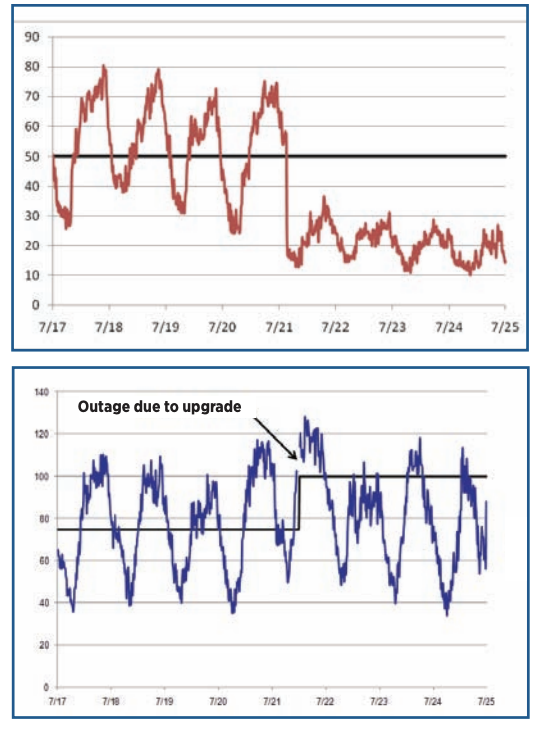


In [1]:
from io import StringIO
import requests
import json
import pandas as pd

allBreakout = pd.read_csv('allT_breakout.csv')
redBreakout = pd.read_csv('redT_breakout.csv')
blueBreakout = pd.read_csv('blueT_breakout.csv')
simulatedNoLows = pd.read_csv('SimulatedTransformer.csv')
InjectedMomentary = pd.read_csv('InjectedMomentary.csv')

# Encode Hourly as a mean and std

Can now sample this distribution for each hour to generate an infinite amount od data

### This statistical part not part of the lab

We read the generated data to simplify training

In [40]:
blueBreakout[['order', 'meanY', 'stdY', 'meanYmean', 'meanYstd']]


,order,meanY,stdY,meanYmean,meanYstd
0,1.0,129.500000,1.290994,154.707804,35.721516
1,2.0,122.000000,2.160247,154.707804,35.721516
2,3.0,121.000000,2.160247,154.707804,35.721516
3,4.0,122.333333,3.162278,154.707804,35.721516
4,5.0,120.500000,1.290994,154.707804,35.721516
...,...,...,...,...,...
328,29.0,131.500000,2.449490,154.707804,35.721516
329,30.0,145.000000,2.943920,154.707804,35.721516
330,31.0,138.500000,1.870829,154.707804,35.721516
331,32.0,129.000000,3.316625,154.707804,35.721516


# This is where I hid the momentary

In [2]:
InjectedMomentary.head()
InjectedMomentary[abs(InjectedMomentary.meanY - InjectedMomentary.newY) > 75]

,Unnamed: 0,D,UD,X,X.1,class,classInt,meanY,meanYmean,meanYstd,newY,order,stdY,InjectionLocation
5635,5635,1,133,5635,60,R,1,199.0,123.76477,46.365381,98.751468,18,5.656854,1
5636,5636,1,133,5636,61,R,1,197.0,123.76477,46.365381,98.751468,19,1.414214,1
5637,5637,1,133,5637,62,R,1,194.4,123.76477,46.365381,98.751468,20,3.361547,1
5638,5638,1,133,5638,63,R,1,194.2,123.76477,46.365381,98.751468,21,4.779586,1


## hides in the data pretty well doesn't it?

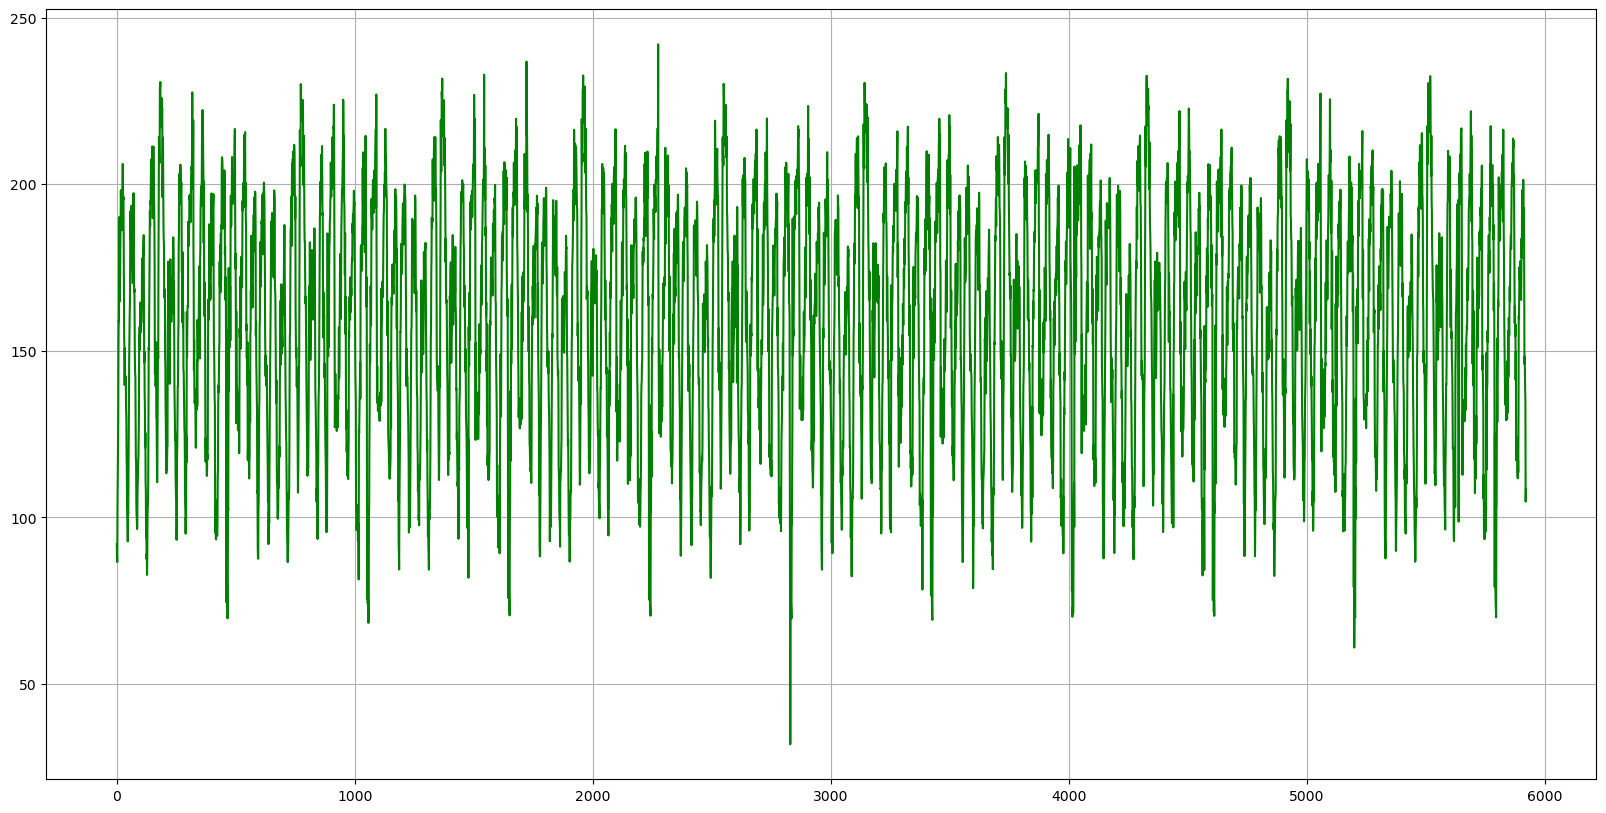

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
#xtx = range(45,500,45)
# set your ticks manually
#ax.xaxis.set_ticks(xtx)
ax.grid(True)
plt.plot(InjectedMomentary.X, InjectedMomentary.newY, c= 'g')

## Zoom in to look at local behavior since I know where to look

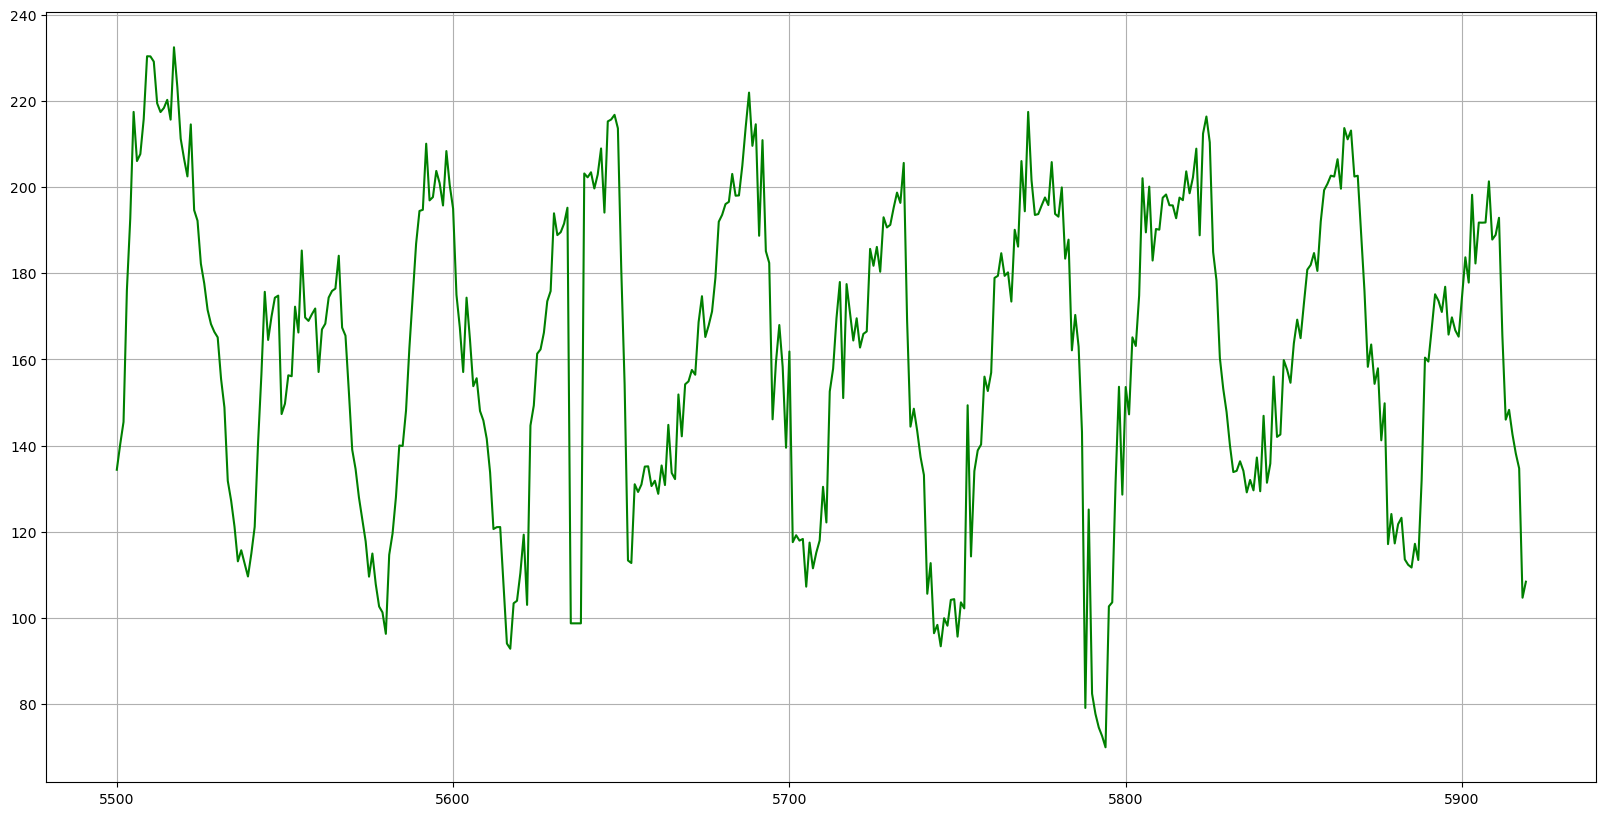

In [4]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
#xtx = range(45,500,45)
# set your ticks manually
#ax.xaxis.set_ticks(xtx)
ax.grid(True)
lo = 5500
hi = 6000
plt.plot(InjectedMomentary.X.iloc[lo:hi], InjectedMomentary.newY.iloc[lo:hi], c= 'g')

In [5]:
injectedMomentaryStart = 5635
injectedMomentaryDuration = 4
injectedMomentaryValue = .5 *  simulatedNoLows.iloc[injectedMomentaryStart:injectedMomentaryStart + injectedMomentaryDuration].newY.max()
InjectedMomentaryNew = simulatedNoLows.copy()
InjectedMomentaryNew.loc[injectedMomentaryStart:injectedMomentaryStart + injectedMomentaryDuration,'newY'] = injectedMomentaryValue

In [6]:
InjectedMomentaryNew.newY[5635]

102.1075427805

In [7]:
simulatedNoLows.newY[5635]

204.215085561

In [8]:
InjectedMomentary

,Unnamed: 0,D,UD,X,X.1,class,classInt,meanY,meanYmean,meanYstd,newY,order,stdY,InjectionLocation
0,0,1,0,0,45,B,0,91.500000,154.707804,35.721516,91.979918,1,0.707107,0
1,1,1,0,1,46,B,0,87.500000,154.707804,35.721516,87.912618,2,1.290994,0
2,2,1,0,2,47,B,0,88.600000,154.707804,35.721516,86.553241,3,3.204164,0
3,3,1,0,3,48,B,0,102.500000,154.707804,35.721516,103.214549,4,0.707107,0
4,4,1,0,4,49,B,0,111.000000,154.707804,35.721516,111.290193,5,1.581139,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,5915,3,139,5915,164,R,1,143.000000,123.764770,46.365381,142.652593,33,1.290994,0
5916,5916,3,139,5916,165,R,1,137.000000,123.764770,46.365381,138.180879,34,1.000000,0
5917,5917,3,139,5917,166,R,1,134.000000,123.764770,46.365381,134.710515,35,1.000000,0
5918,5918,3,139,5918,167,R,1,105.000000,123.764770,46.365381,104.706310,36,1.000000,0


In [9]:
lagDF = InjectedMomentaryNew[['X','newY']]

In [10]:
lagDF['lagY'] =  InjectedMomentaryNew.newY.shift(1)

/tmp/ipykernel_4043585/392049644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lagDF['lagY'] =  InjectedMomentaryNew.newY.shift(1)


In [11]:
lagDF.head()

,X,newY,lagY
0,0,91.117944,NaN
1,1,87.270218,91.117944
2,2,89.902788,87.270218
3,3,102.022914,89.902788
4,4,107.788778,102.022914


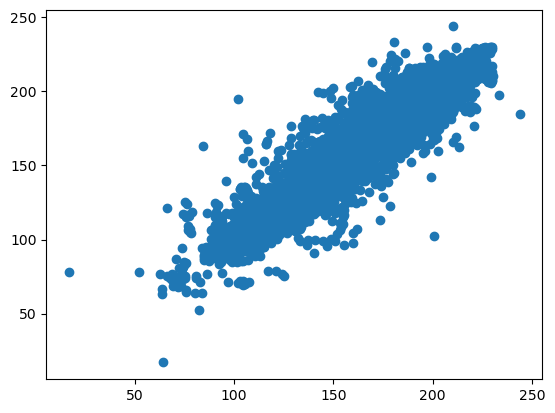

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(lagDF.newY,lagDF.lagY)
plt.show()

In [13]:
mat = lagDF.values[1:,1:]
t = 45*np.pi/180
rot = [[np.cos(t), -np.sin(t)],[np.sin(t),np.cos(t)]]
rot_mat = np.dot(mat,rot)


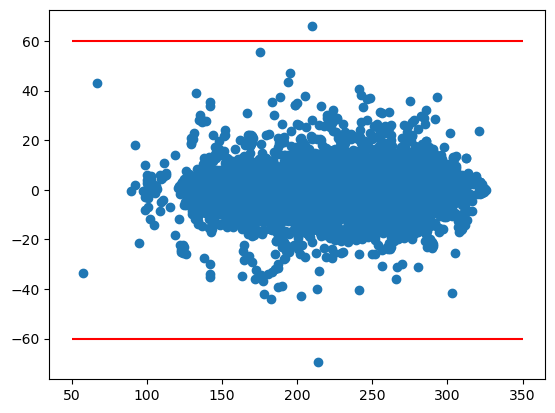

In [14]:
plt.scatter(rot_mat[:,0],rot_mat[:,1])
y_upper = 60
y_lower = -60
plt.hlines([y_upper, y_lower],xmin=50,xmax = 350,color='r')
plt.show()

5634 5639


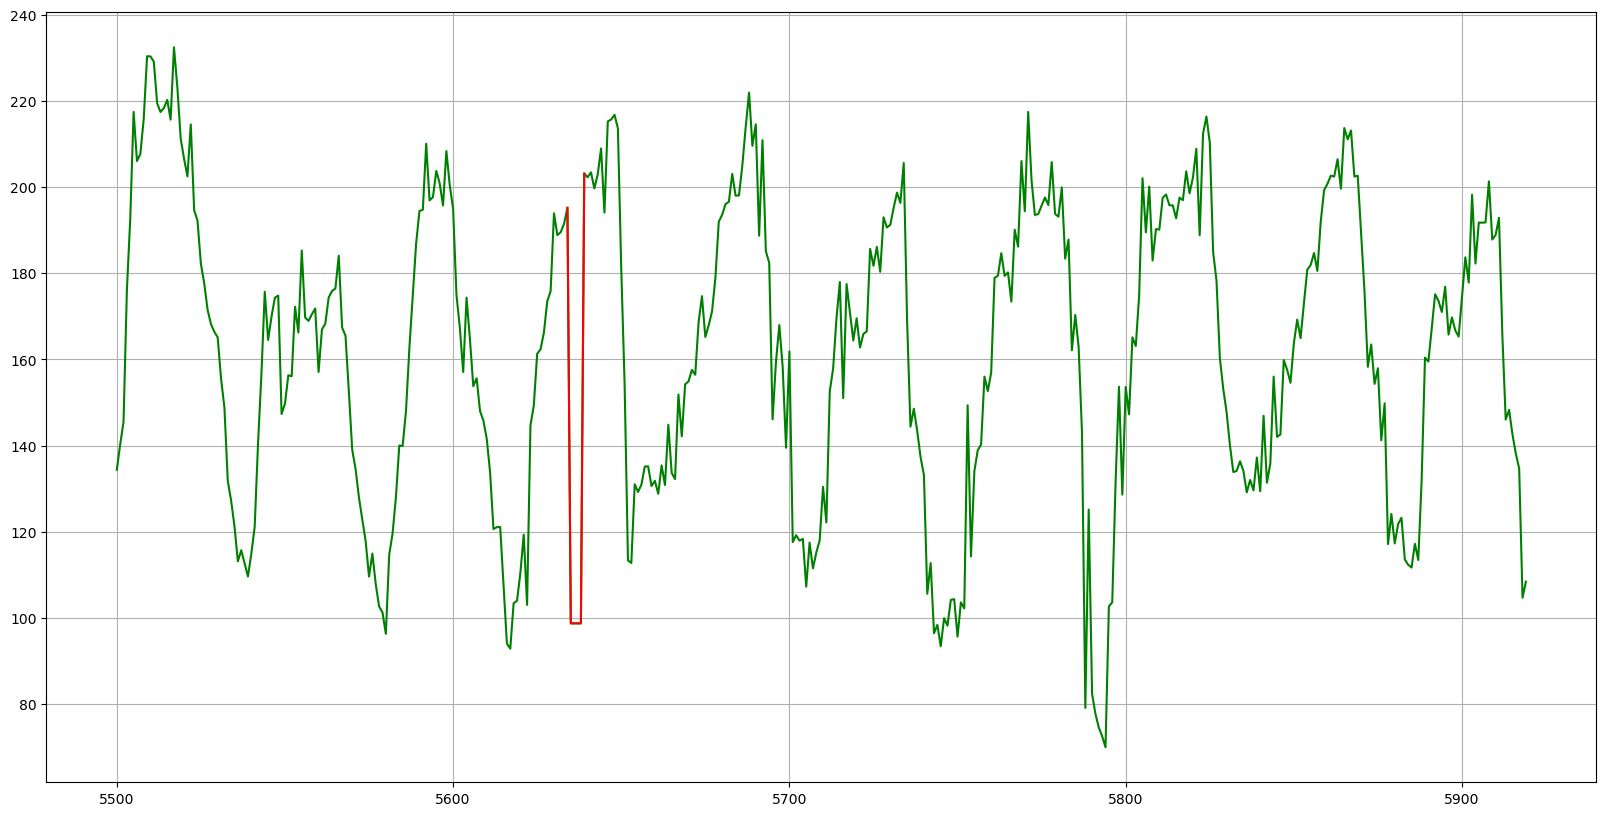

In [52]:
threshold = 60
anamoly_lo = np.argwhere(rot_mat[:,1] > threshold).flatten()[0]
anamoly_hi = np.argwhere(rot_mat[:,1] < -threshold).flatten()[0]
print(anamoly_lo,anamoly_hi)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
#xtx = range(45,500,45)
# set your ticks manually
#ax.xaxis.set_ticks(xtx)
ax.grid(True)
lo = 5500
hi = 6000
plt.plot(InjectedMomentary.X.iloc[lo:hi], InjectedMomentary.newY.iloc[lo:hi], c= 'g')
plt.plot(InjectedMomentary.X.iloc[anamoly_lo:anamoly_hi+1], InjectedMomentary.newY.iloc[anamoly_lo:anamoly_hi+1], c= 'r')

# PCA rotates the matrix also so that PC0 is primary axis, PC1 is Y etc

[0.96914951 0.03085049]
[3792.72838064  676.68628936]


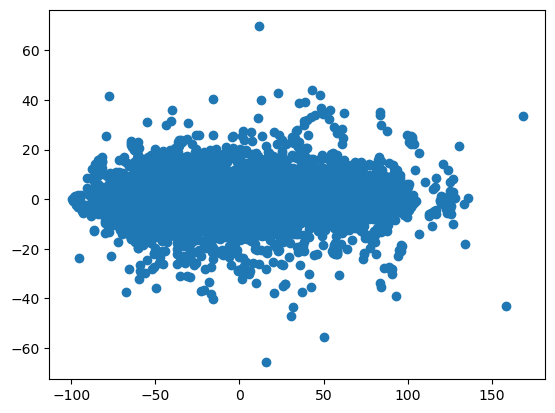

In [24]:
import numpy as np
from sklearn.decomposition import PCA
mat = lagDF.values[1:,1:]
pca = PCA(n_components=2)
pca.fit(mat)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
PCA = pca.transform(mat)
plt.scatter(PCA[:,0], PCA[:,1])

# Finding maxima and minima 

derivative = 0 : doen't always work for real data

Here is a poor mans method using diff()

In [25]:
%%timeit
np.where(InjectedMomentary.newY.diff() == 0)

78.8 µs ± 207 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Here is a faster way using convolution fo find derivative with [-1,1] vector window

In [34]:
%%timeit
np.where( np.convolve(InjectedMomentary.newY, [-1,1]) == 0)

16.5 µs ± 85.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [35]:
np.where( np.convolve(InjectedMomentary.newY, [-1,1]) == 0)

(array([5636, 5637, 5638]),)

In [36]:
t = InjectedMomentary.newY.copy()
b = np.squeeze( np.where(np.convolve(t, [-1,1])==0) )
idx = np.squeeze( np.where(t == t[b[0]]) )
t[idx] = np.NAN
idx,t[idx]

(array([5635, 5636, 5637, 5638]),
 5635   NaN
 5636   NaN
 5637   NaN
 5638   NaN
 Name: newY, dtype: float64)

# What if injection are NAN's , not Zero?

Using convolution trick to look for strings of zeros works when derivative is zero somewhere for a few samples.

But, if NaN
s were present there instead of zeros the convoution speedup track doesn't work - but the lag trick does

In [29]:
s = lagDF.lagY.copy()
c = np.squeeze( np.where(np.convolve(s, [-1,1])==0) )
idx = np.squeeze( np.where(s == s[c[0]]) )
s[idx] = np.NAN
idx

array([5636, 5637, 5638, 5639, 5640])

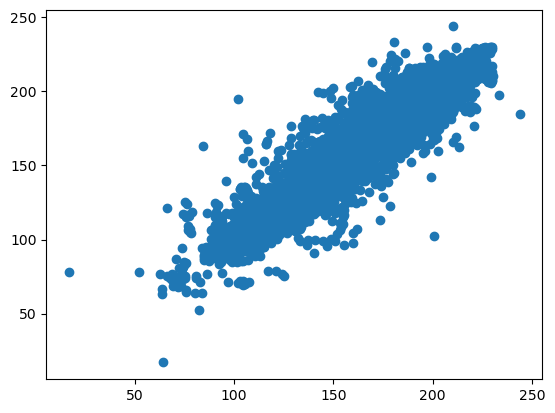

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(lagDF.newY,lagDF.lagY)
plt.show()

In [31]:
mat = lagDF.values[1:,1:]
t = 45*np.pi/180
rot = [[np.cos(t), -np.sin(t)],[np.sin(t),np.cos(t)]]
rot_mat = np.dot(mat,rot)


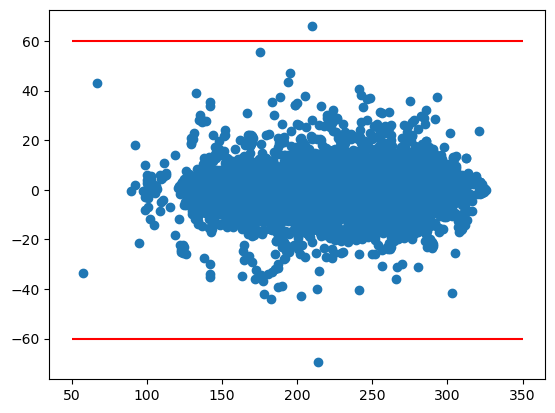

In [32]:
plt.scatter(rot_mat[:,0],rot_mat[:,1])
y_upper = 60
y_lower = -60
plt.hlines([y_upper, y_lower],xmin=50,xmax = 350,color='r')
plt.show()

In [33]:
threshold = 60
anamoly_lo = np.argwhere(rot_mat[:,1] > threshold)
anamoly_hi = np.argwhere(rot_mat[:,1] < -threshold)
anamoly_lo, anamoly_hi

(array([[5634]]), array([[5639]]))